## HE-Only Patch Segmentation

Alyssa Abogado - ResNet34 encoder + UNet-style decoder for HE segmentation

## Imports/Installs
Made for Google Colab

In [ ]:
!pip install segmentation-models-pytorch timm


In [ ]:
import os, json, math, random, shutil
import numpy as np
import pandas as pd
from PIL import Image
import cv2, matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import timm
import albumentations as A
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.decoders.fpn.decoder import FPNDecoder

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
print("PyTorch:", torch.__version__, "| CUDA:", torch.cuda.is_available())


PyTorch: 2.8.0+cu126 | CUDA: True


In [ ]:
!apt-get -y install p7zip-full
!mkdir -p /content/patches_local
!7z x "/content/drive/MyDrive/Gridpatches.7z" -p"DRpatchesWedJul9" -o"/content/patches_local" -y
!find /content/patches_local -maxdepth 2 -type f | head

targets = [("/content/patches", "/content/patches_local"),
           ("/content/patches_local/patches", "/content/patches_local")]
for src, dst in targets:
    if os.path.isdir(src):
        os.makedirs(dst, exist_ok=True)
        for name in os.listdir(src):
            shutil.move(os.path.join(src, name), os.path.join(dst, name))
        shutil.rmtree(src)
        print(f"Flattened {src} -> {dst}")

!mkdir -p /content/Seg-set_local
!unzip -q "/content/drive/MyDrive/Seg-set.zip" -d "/content/Seg-set_local"

!find /content/Seg-set_local -maxdepth 2 -type d | sort
!find /content/Seg-set_local -type f | head

targets = [("/content/Seg-set", "/content/Seg-set_local"),
           ("/content/Seg-set_local/Seg-set", "/content/Seg-set_local")]
for src, dst in targets:
    if os.path.isdir(src):
        os.makedirs(dst, exist_ok=True)
        for name in os.listdir(src):
            shutil.move(os.path.join(src, name), os.path.join(dst, name))
        shutil.rmtree(src)
        print(f"Flattened {src} -> {dst}")

!find /content/Seg-set_local -maxdepth 2 -type d | sort


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 4469852804 bytes (4263 MiB)

Extracting archive: /content/drive/MyDrive/Gridpatches.7z
--
Path = /content/drive/MyDrive/Gridpatches.7z
Type = 7z
Physical Size = 4469852804
Headers Size = 1132420
Method = LZMA2:16 7zAES
Solid = +
Blocks = 275

  0%      0% 5142 - patches/1713_1/frame                                  0% 5578 - patches/000

In [ ]:
ROOT = "/content/patches_local"
PATCH_SIZE = 128
BATCH_SIZE = 4
EPOCHS = 55
PATIENCE = 12
ACCUM_STEPS = 4
BLACK_FRAC_OF_NEG = 0.10
MIN_POS_PIXELS = 12
SAVE_DIR = "./saved_models"
LESION_IDX  = 1          # 0=MA, 1=HE, 2=EX, 3=SE
LESION_NAME = "HE"

LESIONS = ["MA", "HE", "EX", "SE"]
LESION_COLORS = {"MA": (1,0,0), "HE": (0,1,0), "EX": (0,0,1), "SE": (1,1,0)}

MASK_DIRS = {
    "MA": "/content/Seg-set_local/Microaneurysms_Masks",
    "HE": "/content/Seg-set_local/Hemohedge_Masks",
    "EX": "/content/Seg-set_local/HardExudate_Masks",
    "SE": "/content/Seg-set_local/SoftExudate_Masks",
}


In [ ]:
PKL = os.path.join(ROOT, "master_df.pkl")
df = pd.read_pickle(PKL)

def resolve_local(file_path, image_id):
    base = os.path.basename(file_path); iid = str(image_id)
    for p in (
        os.path.join(ROOT, file_path),
        os.path.join(ROOT, "patches", iid, "all", base),
        os.path.join(ROOT, "patches", iid, base),
        os.path.join(ROOT, iid, "all", base),
        os.path.join(ROOT, iid, base),
    ):
        if os.path.exists(p): return p
    return None

df["image_path"] = [resolve_local(fp, iid) for fp, iid in zip(df["file_path"], df["image_id"])]
df = df[df["image_path"].notna()].copy()

def get_top_left(row):
    coords = row.get("coordinates")
    if isinstance(coords, str):
        try: coords = ast.literal_eval(coords)
        except: coords = None
    if isinstance(coords, dict) and "top-left" in coords:
        x, y = coords["top-left"]; return int(x), int(y)
    raise ValueError("Row missing coordinates['top-left']; expected top-left only.")

df["coords"] = df.apply(get_top_left, axis=1)
df = df[df["coords"].notna()].copy()
df["label_vector"] = df["label_vector"].apply(lambda v: list(map(int, v)))

all_data = df[["image_id","image_path","coords","label_vector"]].to_dict("records")
print("records ready:", len(all_data))
print(all_data[0])


records ready: 184200
{'image_id': '0000_1', 'image_path': '/content/patches_local/0000_1/all/0000_1_1216_1216.png', 'coords': (1152, 1152), 'label_vector': [0, 0, 0, 0]}


## Helpers

In [ ]:
def binarize_mask(path):
    if not os.path.exists(path): return None
    return (np.array(Image.open(path).convert("L"))>0).astype(np.uint8)

#load + stack all lesion masks for image
def load_full_masks(image_id):
    m = []
    for les in LESIONS:
        p = os.path.join(MASK_DIRS[les], f"{image_id}.png")
        mm = binarize_mask(p)
        if mm is None: return None
        m.append(mm)
    return np.stack(m, axis=-1)

#crop a mask patch at a top left coord, padding on bottom/right if needed
def crop_patch_mask(full_mask, x, y, size=PATCH_SIZE):
    x,y = max(0,int(x)), max(0,int(y))
    H,W = full_mask.shape[:2]
    ox, oy = max(0, x+size-W), max(0, y+size-H)
    if ox or oy:
        full_mask = np.pad(full_mask, ((0,oy),(0,ox),(0,0)), mode="constant")
    return full_mask[y:y+size, x:x+size, :]

#color overlay masks
def _overlay_on_image(img_rgb, masks_chw, names, alpha=0.45):
    vis = img_rgb.astype(np.float32)/255.0
    for c, name in enumerate(names):
        m = masks_chw[c].astype(bool)
        if m.any():
            color = np.array(LESION_COLORS[name], dtype=np.float32)
            vis[m] = (1-alpha)*vis[m] + alpha*color
    return np.clip(vis, 0, 1)

def _ensure_bchw(x):
    if x.ndim == 4:
        if (x.shape[1] > 8 and x.shape[-1] <= 8) or \
           (x.shape[1] not in (1,2,3,4,5,6,7,8) and x.shape[-1] in (1,2,3,4,5,6,7,8)):
            return x.permute(0, 3, 1, 2).contiguous()
    return x

## Dataset Class

extracts green channel + CLAHE, loads full masks once per image_id then crops the patch for each sample.

In [ ]:
class PatchSegmentationDataset(Dataset):
    '''
    outputs:
      - image: float32, shape (3, H, W), standardized (ImageNet mean/std)
      - mask : float32, shape (1, H, W), in {0., 1.}
    '''
    def __init__(self, df, target_channels=(0,1,2,3), aug=None):
        self.df = pd.DataFrame(df).reset_index(drop=True)
        self.target_channels = list(target_channels)
        self.aug = aug

        # green/CLAHE
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        self._mask_cache = {}

        # constants
        self.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        self.std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    def __len__(self):
        return len(self.df)

    def _get_full_mask(self, image_id):
        m = self._mask_cache.get(image_id)
        if m is None:
            m = load_full_masks(image_id)
            assert m is not None, f"missing masks for image_id={image_id}"
            self._mask_cache[image_id] = m
        return m

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_rgb = np.array(Image.open(row["image_path"]).convert("RGB"))

        # image: use green channel + CLAHE then make 3-ch grayscale
        g = self.clahe.apply(img_rgb[...,1])
        g01 = g.astype(np.float32) / 255.0
        gmix = 0.75 * g01 + 0.25 * (img_rgb[...,1].astype(np.float32)/255.0)
        img = np.repeat(gmix[..., None], 3, axis=-1)

        full_mask = self._get_full_mask(row["image_id"])
        x, y = map(int, row["coords"])
        pm = crop_patch_mask(full_mask, x, y, size=PATCH_SIZE)

        #build HWC mask for channel
        chs = self.target_channels
        if isinstance(chs, (list, tuple, np.ndarray)):
            mask = pm[..., chs]
        else:
            mask = pm[..., int(chs)][..., None]

        mask = (mask > 0).astype(np.float32)

        # MIN_POS_PIXELS guard
        if mask.ndim == 2:
            if mask.sum() < MIN_POS_PIXELS:
                mask[...] = 0.0
            mask = mask[..., None]
        elif mask.ndim == 3 and mask.shape[-1] == 1:      # (S,S,1)
            if mask.sum() < MIN_POS_PIXELS:
                mask[...] = 0.0

        # albumentations joint transform
        if self.aug is not None:
            out = self.aug(image=img, mask=mask)
            img, mask = out["image"], out["mask"]

        img  = (img - self.mean) / self.std
        mask = mask.astype(np.float32)

        img  = np.transpose(img, (2,0,1)).astype(np.float32)     # (3,S,S)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)    # (1,S,S)


        # asserts
        C_img = 3
        C_mask = len(self.target_channels)
        H, W = PATCH_SIZE, PATCH_SIZE
        assert img.shape  == (C_img, H, W),  f"img shape {img.shape} != {(C_img,H,W)}"
        assert mask.shape == (C_mask, H, W), f"mask shape {mask.shape} != {(C_mask,H,W)}"
        assert img.dtype  == np.float32 and mask.dtype == np.float32

        return torch.from_numpy(img), torch.from_numpy(mask)


/tmp/ipython-input-3500859146.py:8: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=PATCH_SIZE, min_width=PATCH_SIZE,


## Balanced task tables + splits

Splits the whole data set 70/15/15, test split aims for 60/40 lesion/healthy

In [ ]:
# image-level split: 70 / 15 / 15
def split_image_level(all_rows, seed=42):
    ids = pd.DataFrame(all_rows)["image_id"].unique()
    tr, tmp = train_test_split(ids, test_size=0.30, random_state=seed)
    va, te  = train_test_split(tmp, test_size=0.50, random_state=seed)
    def _sel(idset):
        df = pd.DataFrame(all_rows)
        return df[df["image_id"].isin(idset)].reset_index(drop=True)
    return _sel(tr), _sel(va), _sel(te)

train_df_all, val_df_all, test_df = split_image_level(all_data, seed=SEED)

def _is_lesion_row(v):
    return int(np.any(np.asarray(v, dtype=int) == 1)) == 1

def _is_healthy_row(v):
    return int(np.sum(np.asarray(v, dtype=int)) == 0) == 1

# global 60/40 sampler (keeps 48/img, enforces 60% lesion overall)
def sample_train(train_df_all, per_image=48, seed=42):
    rng = np.random.default_rng(seed)
    df = pd.DataFrame(train_df_all).copy()
    df["is_pos"] = df["label_vector"].apply(_is_lesion_row)
    df["is_neg"] = 1 - df["is_pos"]

    # per image selection
    POS_FRAC = 0.60
    pos_target_img = int(round(per_image * POS_FRAC))

    chosen = []
    pos_surplus_pool = []           # extra positives
    neg_surplus_pool = []           # extra negatives
    pos_selected = 0
    neg_selected = 0

    g = df.groupby("image_id", sort=False)
    for iid, gdf in g:
        pos_pool = gdf[gdf["is_pos"] == 1]
        neg_pool = gdf[gdf["is_neg"] == 1]

        # pick positives for this image
        if len(pos_pool) >= pos_target_img:
            take_pos = pos_pool.sample(pos_target_img, random_state=seed)
            # keep the rest as surplus
            pos_surplus_pool.append(pos_pool.drop(take_pos.index))
        else:
            take_pos = pos_pool

        # fill remaining with negatives
        need_neg = per_image - len(take_pos)
        if len(neg_pool) >= need_neg:
            take_neg = neg_pool.sample(need_neg, random_state=seed)
            neg_surplus_pool.append(neg_pool.drop(take_neg.index))
        else:
            take_neg = neg_pool
            # if still short, oversample
            need = per_image - (len(take_pos) + len(take_neg))
            if need > 0:
                pool = pd.concat([take_pos, take_neg], ignore_index=False)
                if len(pool) > 0:
                    dup_idx = rng.choice(pool.index.values, size=need, replace=True)
                    take_neg = pd.concat([take_neg, pool.loc[dup_idx]], ignore_index=False)

        pick = pd.concat([take_pos, take_neg], ignore_index=False)
        if len(pick) > per_image:
            pick = pick.sample(per_image, random_state=seed)
        chosen.append(pick)

        pos_selected += int(take_pos.shape[0])
        neg_selected += int(per_image - take_pos.shape[0])

    chosen_df = pd.concat(chosen, ignore_index=False)

    # global ratio correction to hit ~60/40 across whole train
    total = len(chosen_df)
    target_pos = int(round(total * POS_FRAC))
    delta_pos = target_pos - pos_selected

    pos_surplus_all = pd.concat(pos_surplus_pool, ignore_index=False) if len(pos_surplus_pool) else chosen_df.iloc[0:0]
    neg_surplus_all = pd.concat(neg_surplus_pool, ignore_index=False) if len(neg_surplus_pool) else chosen_df.iloc[0:0]

    if delta_pos > 0:
        # need more positives: add from pos surplus and drop same # of negatives
        add_n = min(delta_pos, len(pos_surplus_all))
        if add_n > 0:
            add_idx = rng.choice(pos_surplus_all.index.values, size=add_n, replace=False)
            drop_pool = chosen_df[chosen_df["is_neg"] == 1]
            drop_idx = rng.choice(drop_pool.index.values, size=min(add_n, len(drop_pool)), replace=False)
            chosen_df = chosen_df.drop(drop_idx, errors="ignore")
            chosen_df = pd.concat([chosen_df, pos_surplus_all.loc[add_idx]], ignore_index=False)
    elif delta_pos < 0:
        # too many positives: drop some positives and replace with negatives
        drop_n = min(-delta_pos, len(chosen_df[chosen_df["is_pos"] == 1]))
        if drop_n > 0:
            drop_pool = chosen_df[chosen_df["is_pos"] == 1]
            drop_idx = rng.choice(drop_pool.index.values, size=drop_n, replace=False)
            chosen_df = chosen_df.drop(drop_idx, errors="ignore")
            # add negatives from surplus (or reuse existing negatives if needed)
            if len(neg_surplus_all) >= drop_n:
                add_idx = rng.choice(neg_surplus_all.index.values, size=drop_n, replace=False)
                chosen_df = pd.concat([chosen_df, neg_surplus_all.loc[add_idx]], ignore_index=False)
            else:
                # oversample negatives if needed
                neg_pool = chosen_df[chosen_df["is_neg"] == 1]
                if len(neg_pool) > 0:
                    dup_idx = rng.choice(neg_pool.index.values, size=(drop_n - len(neg_surplus_all)), replace=True)
                    chosen_df = pd.concat([chosen_df, neg_surplus_all, neg_pool.loc[dup_idx]], ignore_index=False)

    chosen_df = chosen_df.reset_index(drop=True)
    cols = ["image_id", "image_path", "coords", "label_vector"]
    return chosen_df[cols].copy()

def sample_fixed_per_image(df_all, n_per_image, seed=42):
    return (df_all.groupby("image_id", group_keys=False)
             .apply(lambda x: x.sample(min(len(x), n_per_image), random_state=seed))
             .reset_index(drop=True))

train_df = sample_train(train_df_all, per_image=48, seed=SEED)
val_df = sample_fixed_per_image(val_df_all, n_per_image=96, seed=SEED)

# aug + preproc
AUG_TRAIN = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Rotate(limit=10, p=0.3),
    A.PadIfNeeded(min_height=PATCH_SIZE, min_width=PATCH_SIZE,
                  border_mode=cv2.BORDER_CONSTANT, value=0),
])

train_ds = PatchSegmentationDataset(train_df, target_channels=[LESION_IDX], aug=AUG_TRAIN)
val_ds   = PatchSegmentationDataset(val_df,   target_channels=[LESION_IDX], aug=None)
test_ds  = PatchSegmentationDataset(test_df,  target_channels=[LESION_IDX], aug=None)

[loaders] train_steps=61872 | val_steps=26496 | test_steps=27700


/tmp/ipython-input-4228790432.py:130: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), n_per_image), random_state=seed))
/tmp/ipython-input-4228790432.py:141: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=PATCH_SIZE, min_width=PATCH_SIZE,


## Loaders + Alignment check

In [ ]:
loader_kw_train = dict(batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True, persistent_workers=True)
loader_kw_eval  = dict(batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

train_loader = DataLoader(
    PatchSegmentationDataset(train_df, target_channels=[LESION_IDX], aug=AUG_TRAIN),
    **loader_kw_train
)
val_loader = DataLoader(
    PatchSegmentationDataset(val_df,   target_channels=[LESION_IDX], aug=None),
    **loader_kw_eval
)
test_loader = DataLoader(
    PatchSegmentationDataset(test_df,  target_channels=[LESION_IDX], aug=None),
    **loader_kw_eval
)

print(f"[loaders] train_steps={len(train_loader)} | val_steps={len(val_loader)} | test_steps={len(test_loader)}")


[loaders] train_steps=15468 | val_steps=6624 | test_steps=6925


## Encoder/Decoder

In [ ]:
def _GN(c, groups=8):
    g = min(groups, c)
    while c % g != 0 and g > 1:
        g -= 1
    return nn.GroupNorm(g, c)

class ConvBNAct(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, d=1, act=True):
        super().__init__()
        p = ((k - 1)//2) * d
        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, dilation=d, bias=False)
        self.bn   = _GN(out_ch)
        self.act  = nn.ReLU(inplace=True) if act else nn.Identity()
    def forward(self, x): return self.act(self.bn(self.conv(x)))

class ResidualDoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, d=1, dropout=0.0):
        super().__init__()
        self.c1 = ConvBNAct(in_ch, out_ch, k=3, d=d, act=True)
        self.c2 = ConvBNAct(out_ch, out_ch, k=3, d=d, act=False)
        self.drop = nn.Identity() if dropout <= 0 else nn.Dropout2d(dropout)
        self.proj = nn.Identity() if in_ch == out_ch else nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.bn_p = nn.Identity() if isinstance(self.proj, nn.Identity) else _GN(out_ch)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x):
        y = self.c2(self.c1(x))
        x = self.bn_p(self.proj(x)) if not isinstance(self.proj, nn.Identity) else x
        y = self.drop(y)
        return self.act(x + y)

class LesionDecoderV2(nn.Module):
  # upsample(enc) -> concat(skip) -> 1x1 fuse -> Res(x2) -> head(out_ch)
    def __init__(self, in_ch, skip_ch, out_ch, mid_ch, use_deconv=False, se_ratio=0.0, dropout=0.0):
        super().__init__()
        self.up   = nn.ConvTranspose2d(in_ch, in_ch, 2, 2) if use_deconv \
                    else nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.fuse = nn.Conv2d(in_ch + skip_ch, mid_ch, 1, bias=False)
        self.fbn  = _GN(mid_ch)
        self.fact = nn.ReLU(inplace=True)
        self.b1   = ResidualDoubleConv(mid_ch, mid_ch, d=1, dropout=dropout)
        self.b2   = ResidualDoubleConv(mid_ch, mid_ch, d=1, dropout=dropout)
        self.head = nn.Conv2d(mid_ch, out_ch, 1)
    def forward(self, enc, skip):
        x = self.up(enc)
        x = torch.cat([x, skip], dim=1)
        x = self.fact(self.fbn(self.fuse(x)))
        x = self.b1(x); x = self.b2(x)
        return self.head(x)

# ResNet34 encoder + explicit UNet decoder
class PatchSegModel(nn.Module):
    def __init__(self, in_ch=3, n_classes=4):
        super().__init__()

        self.encoder = timm.create_model(
            "resnet34.tv_in1k",
            features_only=True,
            pretrained=True,
            out_indices=(1, 2, 3, 4),  # C2(32×32), C3(16×16), C4(8×8), C5(4×4)
            in_chans=in_ch,
        )

        c2, c3, c4, c5 = self.encoder.feature_info.channels()  # [64,128,256,512]

        self.dec54 = LesionDecoderV2(in_ch=c5, skip_ch=c4, out_ch=256, mid_ch=256)
        self.dec43 = LesionDecoderV2(in_ch=256, skip_ch=c3, out_ch=128, mid_ch=128)
        self.dec32 = LesionDecoderV2(in_ch=128, skip_ch=c2, out_ch=64,  mid_ch=64)

        self.up32  = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.post32 = ResidualDoubleConv(64, 64)

        self.up64  = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.post64 = ResidualDoubleConv(64, 64)

        self.decoder = nn.ModuleList([self.dec54, self.dec43, self.dec32, self.post32, self.post64, self.up32, self.up64])

        self.seg_head = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        c2, c3, c4, c5 = self.encoder(x)

        x = self.dec54(c5, c4)
        x = self.dec43(x, c3)
        x = self.dec32(x, c2)

        x = self.up32(x); x = self.post32(x)
        x = self.up64(x); x = self.post64(x)

        return self.seg_head(x)

In [ ]:
@torch.no_grad()
def compute_loader_pos_weight(loader, cap=12.0, device=None):
    total_pos = None
    total_pix = 0

    for _, m in tqdm(loader, desc="Computing pos_weight"):
        # ensure (B,C,H,W)
        if m.ndim == 3:   # (C,H,W)
            m = m.unsqueeze(0)
        m = (m > 0).float()
        B, C, H, W = m.shape

        batch_pos = m.sum(dim=(0,2,3))  # (C,)
        total_pos = batch_pos if total_pos is None else total_pos + batch_pos
        total_pix += B * H * W

    # per-class totals
    total = torch.full_like(total_pos, float(total_pix))
    neg   = total - total_pos
    pw    = (neg / (total_pos + 1e-6)).clamp(1.0, float(cap))  # (C,)

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return pw.to(device)


POS_WEIGHT = compute_loader_pos_weight(train_loader, cap=12.0)
print("pos_weight:", POS_WEIGHT.tolist())
-
torch.save(POS_WEIGHT.cpu(), "pos_weight.pt")

POS_WEIGHT = torch.load("pos_weight.pt").to("cuda" if torch.cuda.is_available() else "cpu")
print("POS_WEIGHT:", POS_WEIGHT.tolist())

Computing pos_weight: 100%|██████████| 15468/15468 [03:12<00:00, 80.36it/s] 

pos_weight: [12.0]


## Training

In [ ]:
def focal_tversky_loss(probs, target, alpha=0.7, beta=0.3, gamma=0.75, eps=1e-6):
    tp = (probs * target).sum(dim=(0,2,3))
    fp = ((1.0 - target) * probs).sum(dim=(0,2,3))
    fn = ((1.0 - probs) * target).sum(dim=(0,2,3))
    tversky = (tp + eps) / (tp + alpha*fn + beta*fp + eps)
    return ((1.0 - tversky)**gamma).mean()

def total_loss(logits, target, *, bce_alpha=0.05, pos_weight=None,
               aux_logits=None, aux_bce_alpha=0.0):
    B, C, H, W = logits.shape

    pw = None
    if pos_weight is not None:
        pw = pos_weight if torch.is_tensor(pos_weight) else torch.tensor(pos_weight)
        pw = pw.to(device=logits.device, dtype=logits.dtype).view(-1)
        if pw.numel() == 1 and C > 1:
            pw = pw.repeat(C)

    probs = torch.sigmoid(logits)
    ft = focal_tversky_loss(probs, target)

    bce = F.binary_cross_entropy_with_logits(
        logits, target, weight=None, reduction="mean", pos_weight=pw
    )

    loss = (1.0 - bce_alpha) * ft + bce_alpha * bce

    if aux_logits:
        for aux in aux_logits:
            if aux is None:
                continue
            tgt = target if aux.shape[2:] == target.shape[2:] \
                  else F.interpolate(target, size=aux.shape[-2:], mode="nearest")
            bce_aux = F.binary_cross_entropy_with_logits(
                aux, tgt, weight=None, reduction="mean", pos_weight=pw
            )
            loss = loss + float(aux_bce_alpha) * bce_aux
    return loss

class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {n: p.detach().clone() for n, p in model.named_parameters() if p.requires_grad}
        self.collected = {}
    @torch.no_grad()
    def update(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n].mul_(self.decay).add_(p.detach(), alpha=1.0 - self.decay)
    @torch.no_grad()
    def apply_to(self, model):
        self.collected = {}
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.collected[n] = p.detach().clone()
                p.data.copy_(self.shadow[n].data)
    @torch.no_grad()
    def restore(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.collected:
                p.data.copy_(self.collected[n].data)
        self.collected = {}

# train + eval
def train_model(model, train_loader, val_loader, *,
                epochs=55, lr=1e-4, accumulation_steps=4,
                ema_decay=0.999, aux_bce_alpha=0.0,
                pos_weight=None, tau_grids=None, sweep_every=5):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).train()

    pw = None if pos_weight is None else (
        pos_weight if torch.is_tensor(pos_weight) else torch.tensor(pos_weight)
    ).to(device)

    # params
    params = []
    if hasattr(model, "encoder"): params.append({"params": model.encoder.parameters(), "lr": lr})
    if hasattr(model, "decoder"): params.append({"params": model.decoder.parameters(), "lr": lr})
    if hasattr(model, "seg_head"): params.append({"params": model.seg_head.parameters(), "lr": lr * 10})

    opt = AdamW(params, weight_decay=1e-4, betas=(0.9, 0.999), eps=1e-8)
    scheduler = ReduceLROnPlateau(opt, mode="max", factor=0.5, patience=2, min_lr=1e-6)
    scaler = torch.amp.GradScaler(enabled=(device.type == "cuda"))
    ema = EMA(model, decay=ema_decay)

    best_metric, wait = -1e9, 0
    MIN_DELTA, PATIENCE = 0.002, 8
    best_taus = None

    for ep in range(1, epochs + 1):
        model.train()
        tr_loss = 0.0
        opt.zero_grad(set_to_none=True)

        pbar = tqdm(train_loader, desc=f"Epoch {ep}/{epochs} [train]", leave=False)
        for step, (x, y) in enumerate(pbar, 1):
            x = x.to(device).float()
            y = y.to(device).float()

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
                out = model(x)
                logits = out if not isinstance(out, (tuple, list)) else out[0]   # (B,4,H,W)
                aux_logits = None if not isinstance(out, (tuple, list)) else list(out[1:])

                # sanity check
                if ep == 1 and step == 1:
                    print("[debug] x", tuple(x.shape), "y", tuple(y.shape), "logits", tuple(logits.shape))
                    if not hasattr(total_loss, "_dbg"):
                        print("[dbg] BCE shapes — logits:", tuple(logits.shape),
                              "pos_weight:", (None if pw is None else tuple(pw.shape)))
                        total_loss._dbg = True


                loss = total_loss(
                    logits, y, bce_alpha=0.05,
                    pos_weight=pw, aux_logits=aux_logits, aux_bce_alpha=aux_bce_alpha
                )

            scaler.scale(loss / accumulation_steps).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            if step % accumulation_steps == 0:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(opt); scaler.update()
                opt.zero_grad(set_to_none=True)
                ema.update(model)

            tr_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        tr_loss /= max(1, len(train_loader))

        # val on EMA
        model.eval(); ema.apply_to(model)
        val_sum, batches = 0.0, 0
        with torch.no_grad():
            pbar_val = tqdm(val_loader, desc=f"Epoch {ep}/{epochs} [val]", leave=False)
            for x, y in pbar_val:
                x = x.to(device).float()
                y = y.to(device).float()

                pred  = model(x)
                probs = torch.sigmoid(pred)

                if y.shape[2:] != probs.shape[2:]:
                    y = F.interpolate(y, size=probs.shape[-2:], mode="nearest")

                inter = (probs * y).sum(dim=(0,2,3))
                p = probs.sum(dim=(0,2,3)); t = y.sum(dim=(0,2,3))
                dice_c = (2.0*inter + 1e-6) / (p + t + 1e-6)

                mask_pos = (t > 0)
                if mask_pos.any():
                    val_sum += dice_c[mask_pos].mean().item()
                    batches += 1

        val_dice_mean_ema = val_sum / max(1, batches)
        ema.restore(model)

        scheduler.step(val_dice_mean_ema)
        print(f"Ep{ep:03d} | TrainLoss {tr_loss:.4f} | ValDice(mean, EMA) {val_dice_mean_ema:.4f}")

        # optional threshold sweep
        if (tau_grids is not None) and (ep % int(sweep_every) == 0):
            sweep = sweep_thresholds(model, val_loader, tau_grids, ema=ema)
            best_taus = sweep["taus"]
            setattr(model, "_best_taus", best_taus)
            print(f"[Epoch {ep}] threshold sweep -> taus={best_taus} | hard_dice={sweep['hard_dice']}")

        # early stopping / checkpoint
        if val_dice_mean_ema > best_metric + MIN_DELTA:
            best_metric, wait = val_dice_mean_ema, 0
            torch.save(model.state_dict(), "best_model.pt")
            if best_taus is not None:
                with open("best_thresholds.json", "w") as f:
                    json.dump({"epoch": ep, "taus": best_taus}, f)
        else:
            wait += 1
            if wait >= PATIENCE:
                print("Early stopping.")
                break

    # final sweep if never done
    if (tau_grids is not None) and (getattr(model, "_best_taus", None) is None):
        sweep = sweep_thresholds(model, val_loader, tau_grids, ema=ema)
        best_taus = sweep["taus"]
        setattr(model, "_best_taus", best_taus)
        print(f"[Final] threshold sweep -> taus={best_taus} | hard_dice={sweep['hard_dice']}")

    return model


## Train Task models

In [ ]:
@torch.no_grad()
def sweep_thresholds(model, loader, tau_grids, ema=None):
    # threshold sweep per class to maximize hard dice
    device = next(model.parameters()).device
    model.eval()
    if ema is not None:
        ema.apply_to(model)

    P_list, T_list = [], []
    for x, y in loader:
        x = x.to(device).float()
        y = y.to(device).float()
        logits = model(x)
        if logits.shape[-2:] != y.shape[-2:]:
            logits = F.interpolate(logits, size=y.shape[-2:], mode="bilinear", align_corners=False)
        P_list.append(torch.sigmoid(logits).cpu())
        T_list.append(y.cpu())

    if ema is not None:
        ema.restore(model)

    probs = torch.cat(P_list, 0).numpy()
    gt    = torch.cat(T_list, 0).numpy()
    N, C, H, W = probs.shape

    if isinstance(tau_grids, (list, tuple)):
        if len(tau_grids) == 1 and C > 1:
            tau_grids = list(tau_grids) * C
    else:
        # single ndarray -> apply to all classes
        tau_grids = [np.asarray(tau_grids, dtype=float)] * C

    best_tau  = [0.5] * C
    best_dice = [0.0] * C
    eps = 1e-6

    for c in range(C):
        grid = np.asarray(tau_grids[c], dtype=float)
        if grid.ndim != 1 or grid.size == 0:
            continue
        if gt[:, c].sum() == 0:
            continue

        Pc = probs[:, c]
        Gc = gt[:, c]

        Th = grid[:, None, None, None]
        B  = (Pc[None, ...] > Th).astype(np.float32)

        inter = (B * Gc[None, ...]).sum(axis=(1,2,3))
        ps    = B.sum(axis=(1,2,3))
        ts    = np.full_like(ps, Gc.sum(), dtype=np.float64)

        dice  = (2.0 * inter + eps) / (ps + ts + eps)
        i     = int(dice.argmax())
        best_tau[c]  = float(grid[i])
        best_dice[c] = float(dice[i])

    return {"taus": best_tau, "hard_dice": best_dice}


In [ ]:
model = PatchSegModel(in_ch=3, n_classes=1)

tau_grids = np.linspace(0.30, 0.80, 26),
model = train_model(model, train_loader, val_loader,
                    epochs=55, lr=1e-4, accumulation_steps=4,
                    ema_decay=0.999, aux_bce_alpha=0.0, pos_weight=POS_WEIGHT,
                    tau_grids=tau_grids, sweep_every=5)
# best taus are on model._best_taus (and in best_thresholds.json)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Epoch 1/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

[debug] x (4, 3, 128, 128) y (4, 1, 128, 128) logits (4, 1, 128, 128)
[dbg] BCE shapes — logits: (4, 1, 128, 128) pos_weight: (1,)


Epoch 1/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep001 | TrainLoss 0.8663 | ValDice(mean, EMA) 0.2551


Epoch 2/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 2/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep002 | TrainLoss 0.8159 | ValDice(mean, EMA) 0.3251


Epoch 3/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 3/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep003 | TrainLoss 0.7993 | ValDice(mean, EMA) 0.3448


Epoch 4/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 4/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep004 | TrainLoss 0.8009 | ValDice(mean, EMA) 0.3610


Epoch 5/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 5/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep005 | TrainLoss 0.7838 | ValDice(mean, EMA) 0.3559
[Epoch 5] threshold sweep -> taus=[0.3] | hard_dice=[0.41527084136141773]


Epoch 6/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 6/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep006 | TrainLoss 0.7879 | ValDice(mean, EMA) 0.3514


Epoch 7/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 7/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep007 | TrainLoss 0.7761 | ValDice(mean, EMA) 0.3671


Epoch 8/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 8/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep008 | TrainLoss 0.7789 | ValDice(mean, EMA) 0.3344


Epoch 9/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 9/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep009 | TrainLoss 0.7668 | ValDice(mean, EMA) 0.3720


Epoch 10/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 10/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep010 | TrainLoss 0.7681 | ValDice(mean, EMA) 0.3708
[Epoch 10] threshold sweep -> taus=[0.52] | hard_dice=[0.47373908662696584]


Epoch 11/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 11/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep011 | TrainLoss 0.7623 | ValDice(mean, EMA) 0.3754


Epoch 12/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 12/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep012 | TrainLoss 0.7645 | ValDice(mean, EMA) 0.3632


Epoch 13/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 13/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep013 | TrainLoss 0.7612 | ValDice(mean, EMA) 0.3765


Epoch 14/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 14/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep014 | TrainLoss 0.7556 | ValDice(mean, EMA) 0.3708


Epoch 15/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 15/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep015 | TrainLoss 0.7525 | ValDice(mean, EMA) 0.3723
[Epoch 15] threshold sweep -> taus=[0.8] | hard_dice=[0.434833534473617]


Epoch 16/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 16/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep016 | TrainLoss 0.7505 | ValDice(mean, EMA) 0.3749


Epoch 17/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 17/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep017 | TrainLoss 0.7372 | ValDice(mean, EMA) 0.3703


Epoch 18/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 18/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep018 | TrainLoss 0.7311 | ValDice(mean, EMA) 0.3943


Epoch 19/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 19/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep019 | TrainLoss 0.7494 | ValDice(mean, EMA) 0.3819


Epoch 20/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 20/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep020 | TrainLoss 0.7347 | ValDice(mean, EMA) 0.3939
[Epoch 20] threshold sweep -> taus=[0.8] | hard_dice=[0.46936556125066364]


Epoch 21/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 21/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep021 | TrainLoss 0.7200 | ValDice(mean, EMA) 0.3993


Epoch 22/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 22/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep022 | TrainLoss 0.7277 | ValDice(mean, EMA) 0.3744


Epoch 23/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 23/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep023 | TrainLoss 0.7289 | ValDice(mean, EMA) 0.3915


Epoch 24/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 24/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep024 | TrainLoss 0.7249 | ValDice(mean, EMA) 0.3649


Epoch 25/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 25/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep025 | TrainLoss 0.7197 | ValDice(mean, EMA) 0.4006
[Epoch 25] threshold sweep -> taus=[0.6799999999999999] | hard_dice=[0.4949633653498786]


Epoch 26/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 26/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep026 | TrainLoss 0.7172 | ValDice(mean, EMA) 0.3984


Epoch 27/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 27/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep027 | TrainLoss 0.7114 | ValDice(mean, EMA) 0.3955


Epoch 28/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 28/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep028 | TrainLoss 0.7126 | ValDice(mean, EMA) 0.4013


Epoch 29/55 [train]:   0%|          | 0/15468 [00:00<?, ?it/s]

Epoch 29/55 [val]:   0%|          | 0/6624 [00:00<?, ?it/s]

Ep029 | TrainLoss 0.7173 | ValDice(mean, EMA) 0.3941
Early stopping.


In [ ]:
#final sweep
import numpy as np, json

grid = np.linspace(0.50, 0.95, 24)
sweep = sweep_thresholds(model, val_loader, grid)

best_taus = sweep["taus"]
best_hd   = sweep["hard_dice"]

print(f"Best tau (HE): {best_taus[0]:.3f} | hard_dice: {best_hd[0]:.3f}")

setattr(model, "_best_taus", best_taus)
with open("best_thresholds.json", "w") as f:
    json.dump({"taus": best_taus}, f)

TAU = best_taus[0]


Best tau (HE): 0.833 | hard_dice: 0.399


## Evaluation

In [ ]:
# evaluator
@torch.no_grad()
def per_class_table(model, loader,
                    class_names=("HE",),
                    thresholds=None,
                    thresh=0.30,
                    return_df=False):
    device = next(model.parameters()).device
    model.eval()

    hard_inter_tot = hard_pred_tot = targ_tot = None
    soft_inter_tot = soft_prob_tot = None
    C = None

    for x, y in loader:
        x = _ensure_bchw(x).to(device).float()
        logits = model(x)
        probs  = torch.sigmoid(logits)

        y = _ensure_bchw(y)
        if y.ndim == 4 and y.shape[2:] != probs.shape[2:]:
            y = F.interpolate(y.float(), size=probs.shape[-2:], mode="nearest")
        y = y.to(device).float()

        C = probs.shape[1]

        if thresholds is None:
            tau_list = [thresh] * C
        else:
            th = list(thresholds)
            if len(th) == 1 and C > 1:
                tau_list = th * C
            else:
                tau_list = th
        tau = torch.tensor(tau_list, dtype=probs.dtype, device=probs.device).view(1, C, 1, 1)

        pred = (probs > tau).float()

        inter_h = (pred * y).sum(dim=(0,2,3)).detach().cpu()
        p_h     = pred.sum(dim=(0,2,3)).detach().cpu()
        t_sum   = y.sum(dim=(0,2,3)).detach().cpu()

        inter_s = (probs * y).sum(dim=(0,2,3)).detach().cpu()
        p_s     = probs.sum(dim=(0,2,3)).detach().cpu()

        if hard_inter_tot is None:
            hard_inter_tot = inter_h.clone().zero_()
            hard_pred_tot  = p_h.clone().zero_()
            targ_tot       = t_sum.clone().zero_()
            soft_inter_tot = inter_s.clone().zero_()
            soft_prob_tot  = p_s.clone().zero_()

        hard_inter_tot += inter_h
        hard_pred_tot  += p_h
        targ_tot       += t_sum
        soft_inter_tot += inter_s
        soft_prob_tot  += p_s

    eps=1e-6
    hard_dice = (2*hard_inter_tot + eps) / (hard_pred_tot + targ_tot + eps)
    hard_iou  = (hard_inter_tot + eps) / (hard_pred_tot + targ_tot - hard_inter_tot + eps)
    soft_dice = (2*soft_inter_tot + eps) / (soft_prob_tot + targ_tot + eps)
    soft_iou  = (soft_inter_tot + eps) / (soft_prob_tot + targ_tot - soft_inter_tot + eps)

    names = (list(class_names) if len(class_names)==len(hard_dice)
             else [f"C{i}" for i in range(len(hard_dice))])

    table = pd.DataFrame({
        "class": names,
        "hard_dice": hard_dice.numpy(),
        "hard_iou":  hard_iou.numpy(),
        "soft_dice": soft_dice.numpy(),
        "soft_iou":  soft_iou.numpy(),
        "targ_px":   targ_tot.numpy().astype(int),
        "pred_px":   hard_pred_tot.numpy().astype(int)
    }).set_index("class")

    # macro
    mask_pos = (table["targ_px"] > 0)
    if mask_pos.any():
        macro = pd.Series({
            "hard_dice": table.loc[mask_pos, "hard_dice"].mean(),
            "hard_iou":  table.loc[mask_pos, "hard_iou"].mean(),
            "soft_dice": table.loc[mask_pos, "soft_dice"].mean(),
            "soft_iou":  table.loc[mask_pos, "soft_iou"].mean(),
            "targ_px":   table.loc[mask_pos, "targ_px"].sum(),
            "pred_px":   table.loc[mask_pos, "pred_px"].sum()
        }, name="macro(+)")
        table = pd.concat([table, macro.to_frame().T])

    display(table.style.format("{:.3f}", subset=["hard_dice","hard_iou","soft_dice","soft_iou"]))
    return table if return_df else None


In [ ]:
taus = getattr(model, "_best_taus", [0.35])
per_class_table(model, val_loader,  class_names=(LESION_NAME,), thresholds=taus)
per_class_table(model, test_loader, class_names=(LESION_NAME,), thresholds=taus)


Thresholds used for viz: [0.8326086956521739]

=== VAL: Best / Middle / Worst ===


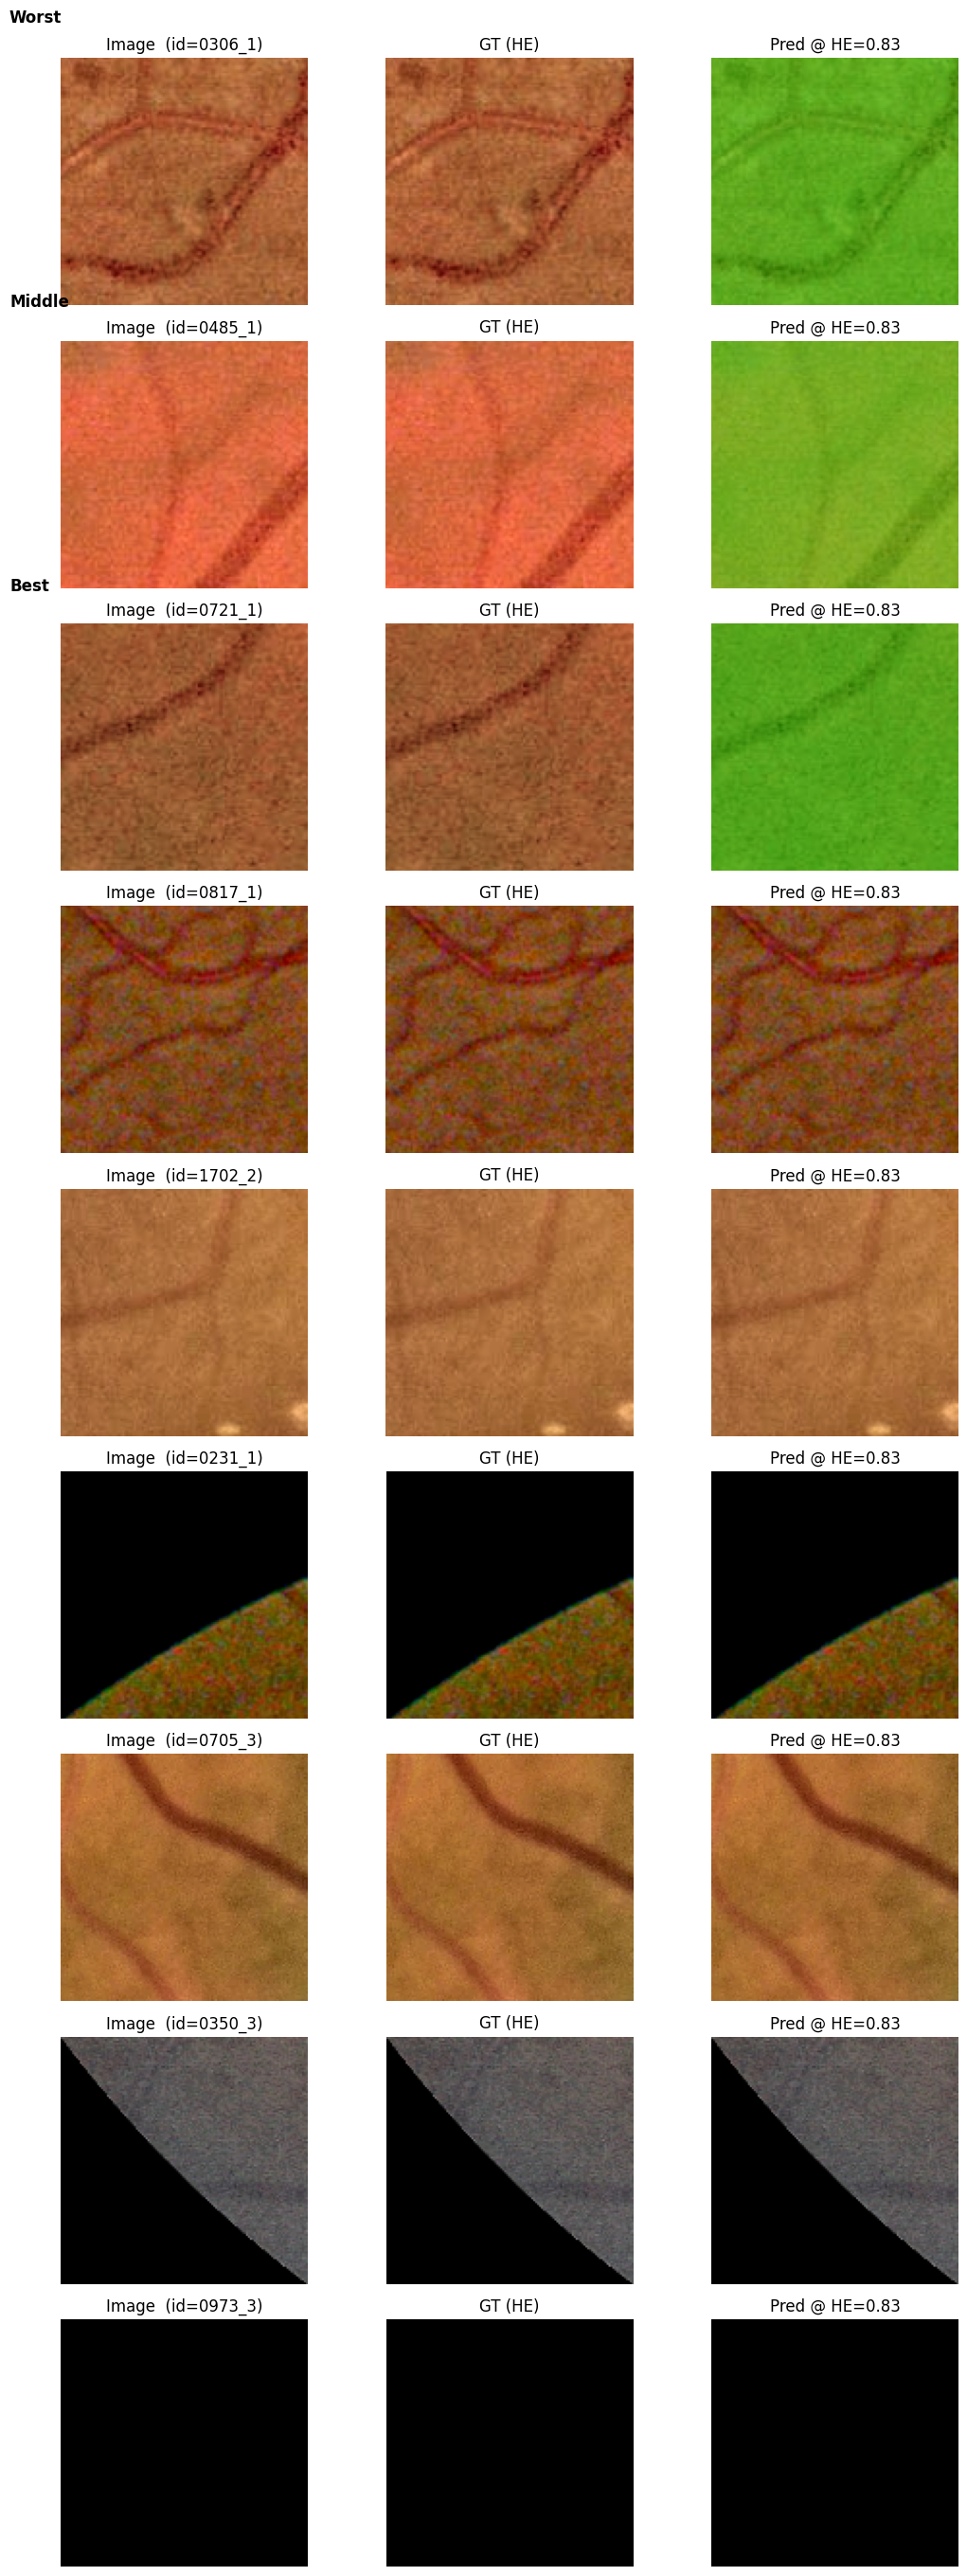


=== TEST: Best / Middle / Worst ===


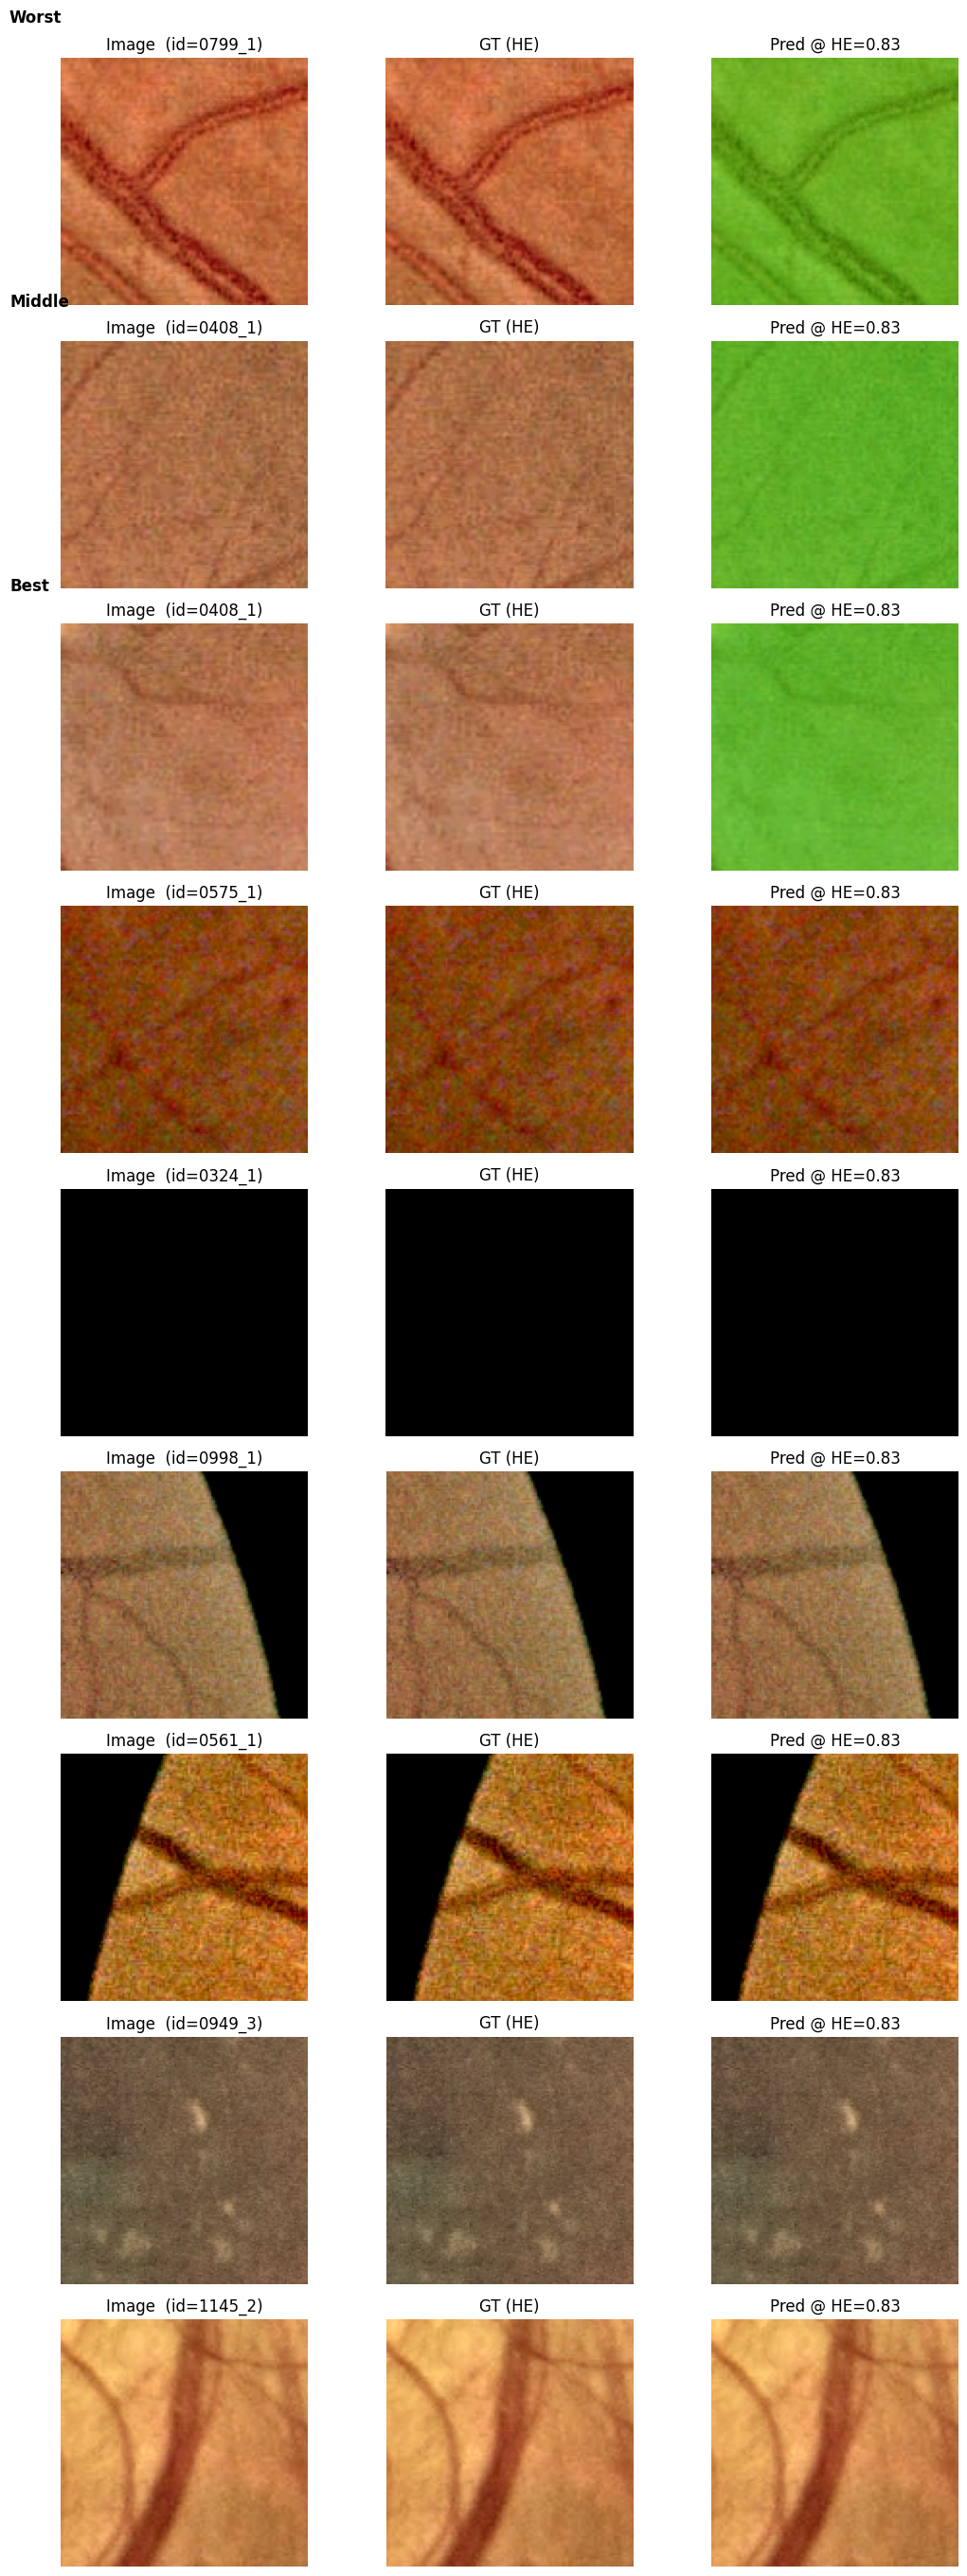

In [ ]:
# Best / Middle / Worst visualization using tuned thresholds
DEFAULT_THRESHOLDS = [0.30]

def _get_eval_thresholds(model, fallback=DEFAULT_THRESHOLDS):
    taus = getattr(model, "_best_taus", None)
    if taus is None:
        return list(fallback)
    return list(taus)

def _map_thresholds_to_task(thresholds_all, task_idxs):
    if len(thresholds_all) == 1:
        return [float(thresholds_all[0])] * len(task_idxs)
    return [float(thresholds_all[i]) for i in task_idxs]

@torch.no_grad()
def _per_sample_hard_dice(model, dataset, idx, thresholds_all):
    device = next(model.parameters()).device
    task_idxs  = getattr(dataset, "target_channels", list(range(1)))
    task_names = [LESIONS[i] for i in task_idxs] if 'LESIONS' in globals() else [f"C{i}" for i in range(len(task_idxs))]
    tau_list   = _map_thresholds_to_task(thresholds_all, task_idxs)
    tau        = np.asarray(tau_list, dtype=np.float32)[:, None, None]

    x, y = dataset[idx]
    x = x.unsqueeze(0).to(device).float()
    gt = y.numpy().astype(np.float32)

    probs = torch.sigmoid(model(x))[0].detach().cpu().numpy()
    pred  = (probs > tau).astype(np.float32)

    inter = (pred * gt).sum(axis=(1,2))
    p     = pred.sum(axis=(1,2))
    t     = gt.sum(axis=(1,2))
    eps = 1e-6
    dice_c = (2*inter + eps) / (p + t + eps)

    pos_mask = (t > 0)
    return float(dice_c[pos_mask].mean()) if pos_mask.any() else float(dice_c.mean())

@torch.no_grad()
def _rank_indices_by_hard_dice(model, dataset, thresholds_all, max_eval=None, seed=123):
    rng = random.Random(seed)
    pool = list(range(len(dataset)))
    if (max_eval is not None) and (max_eval < len(pool)):
        pool = rng.sample(pool, max_eval)

    scores = []
    for idx in pool:
        s = _per_sample_hard_dice(model, dataset, idx, thresholds_all)
        scores.append((idx, s))

    scores.sort(key=lambda t: t[1])
    return scores

@torch.no_grad()
def viz_best_mid_worst(model, dataset, n_each=4, thresholds=None, seed=123, max_eval=1000):
    #shows 'n_each' worst, 'n_each' middle, and 'n_each' best examples
    device = next(model.parameters()).device
    model.eval()

    thresholds_all = _get_eval_thresholds(model, DEFAULT_THRESHOLDS) if thresholds is None else list(thresholds)

    # rank indices
    ranked = _rank_indices_by_hard_dice(model, dataset, thresholds_all, max_eval=max_eval, seed=seed)
    if len(ranked) == 0:
        print("Nothing")
        return

    worst_idx = [i for i,_ in ranked[:n_each]]
    best_idx  = [i for i,_ in ranked[-n_each:]]
    mid_start = max(0, len(ranked)//2 - n_each//2)
    middle_idx = [i for i,_ in ranked[mid_start:mid_start+n_each]]

    groups = [("Worst", worst_idx), ("Middle", middle_idx), ("Best", best_idx)]

    # map thresholds to dataset target channels
    task_idxs  = getattr(dataset, "target_channels", list(range(1)))
    task_names = [LESIONS[i] for i in task_idxs] if 'LESIONS' in globals() else [f"C{i}" for i in range(len(task_idxs))]
    tau_list   = _map_thresholds_to_task(thresholds_all, task_idxs)
    tau_arr    = np.asarray(tau_list, dtype=np.float32)[:, None, None]
    tau_caption= ", ".join(f"{n}={t:.2f}" for n,t in zip(task_names, tau_list))

    total_rows = sum(len(ix) for _, ix in groups)
    fig, axes = plt.subplots(total_rows, 3, figsize=(11, 3*total_rows))
    if total_rows == 1: axes = np.expand_dims(axes, 0)

    row_ptr = 0
    for label, idx_list in groups:
        if len(idx_list) == 0:
            continue
        plt.figtext(0.02, 1 - (row_ptr / max(1,total_rows)) * (3/total_rows), f"{label}", fontsize=12, weight="bold")

        for idx in idx_list:
            row = dataset.df.iloc[idx]
            img_rgb = np.array(Image.open(row["image_path"]).convert("RGB"))

            x, y = dataset[idx]
            x = x.unsqueeze(0).to(device).float()
            gt = y.numpy().astype(np.float32)

            logits = model(x)
            probs  = torch.sigmoid(logits)[0].cpu().numpy()
            pred   = (probs > tau_arr).astype(np.float32)

            gt_vis   = _overlay_on_image(img_rgb, gt,   task_names, alpha=0.45)
            pred_vis = _overlay_on_image(img_rgb, pred, task_names, alpha=0.45)

            ax_img, ax_gt, ax_pr = axes[row_ptr]
            ax_img.imshow(img_rgb); ax_img.set_axis_off(); ax_img.set_title(f"Image  (id={row['image_id']})")
            ax_gt.imshow(gt_vis);   ax_gt.set_axis_off();  ax_gt.set_title(f"GT ({', '.join(task_names)})")
            ax_pr.imshow(pred_vis); ax_pr.set_axis_off();  ax_pr.set_title(f"Pred @ {tau_caption}")

            row_ptr += 1

    plt.tight_layout(); plt.show()

used_taus = _get_eval_thresholds(model, DEFAULT_THRESHOLDS)
print("Thresholds used for viz:", used_taus)

print("\n=== VAL: Best / Middle / Worst ===")
viz_best_mid_worst(model, val_loader.dataset, n_each=3, thresholds=used_taus, seed=123, max_eval=1500)

print("\n=== TEST: Best / Middle / Worst ===")
viz_best_mid_worst(model, test_loader.dataset, n_each=3, thresholds=used_taus, seed=123, max_eval=1500)


## 1686_3 HE-only

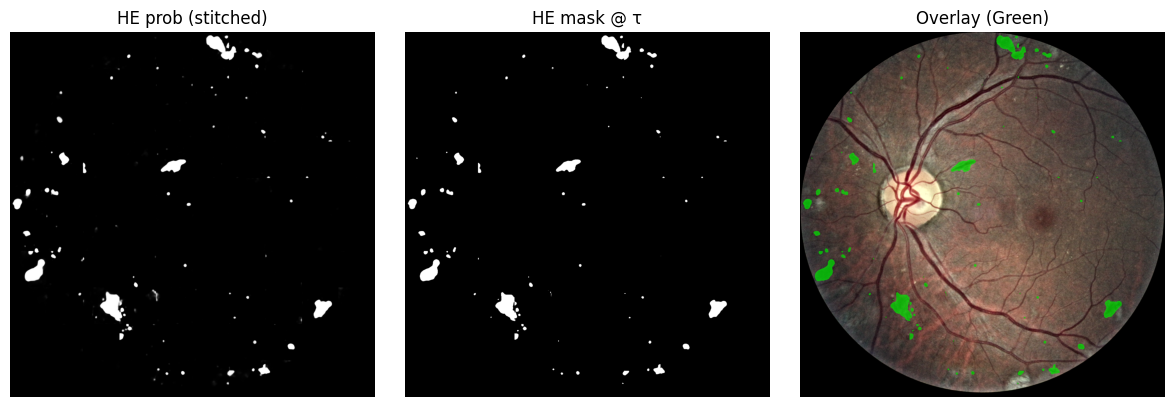

[saved] ./viz_1686_heonly/1686_3_HE_prob_uint8.png
[saved] ./viz_1686_heonly/1686_3_HE_mask.png
[saved] ./viz_1686_heonly/1686_3_HE_overlay_green.png


In [ ]:
TARGET_ID   = "1686_3"
PATCH_SIZE  = PATCH_SIZE
SAVE_DIR    = "./viz_1686_heonly"
os.makedirs(SAVE_DIR, exist_ok=True)

HE_COLOR_FLOAT = np.array([0.0, 1.0, 0.0], dtype=np.float32)
ALPHA = 0.65

if hasattr(model, "_best_taus"):
    tau_he = float(model._best_taus[0])
else:
    tau_he = 0.75

def _load_full_image(image_id):
    candidates = []
    if 'Seg-set_local' in os.listdir('/content'):
        odir = "/content/Seg-set_local/Original_Images"
        candidates += [os.path.join(odir, f"{image_id}.png"),
                       os.path.join(odir, f"{image_id}.jpg"),
                       os.path.join(odir, f"{image_id}.jpeg")]
    for p in candidates:
        if os.path.exists(p):
            return np.array(Image.open(p).convert("RGB"))
    return None

_rows_src = df if isinstance(df, pd.DataFrame) else pd.DataFrame(all_data)
rows_id = _rows_src[_rows_src["image_id"].astype(str) == str(TARGET_ID)].copy()
rows_id = rows_id.sort_values(by=["coords"]).reset_index(drop=True)

full_masks = load_full_masks(TARGET_ID)
if full_masks is not None:
    H_full, W_full = full_masks.shape[:2]
else:
    xs = [int(xy[0]) for xy in rows_id["coords"]]
    ys = [int(xy[1]) for xy in rows_id["coords"]]
    W_full = max(xs) + PATCH_SIZE
    H_full = max(ys) + PATCH_SIZE

prob_full = np.zeros((H_full, W_full), dtype=np.float32)
count_full = np.zeros((H_full, W_full), dtype=np.float32)

device = next(model.parameters()).device
model.eval()

@torch.no_grad()
def _prep_patch_tensor(img_rgb):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    g = clahe.apply(img_rgb[...,1])
    g01 = g.astype(np.float32)/255.0
    gmix = 0.75*g01 + 0.25*(img_rgb[...,1].astype(np.float32)/255.0)
    img = np.repeat(gmix[...,None], 3, axis=-1)

    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    img = (img - mean) / std
    img = np.transpose(img, (2,0,1)).astype(np.float32)
    return torch.from_numpy(img).unsqueeze(0).to(device)

base_full = _load_full_image(TARGET_ID)
if base_full is None:
    base_full = np.zeros((H_full, W_full, 3), dtype=np.uint8)
    for _, row in rows_id.iterrows():
        x, y = map(int, row["coords"])
        patch = np.array(Image.open(row["image_path"]).convert("RGB"))
        H, W = patch.shape[:2]
        base_full[y:y+H, x:x+W, :] = patch

for _, row in rows_id.iterrows():
    x, y = map(int, row["coords"])
    patch_rgb = np.array(Image.open(row["image_path"]).convert("RGB"))
    if patch_rgb.shape[0] != PATCH_SIZE or patch_rgb.shape[1] != PATCH_SIZE:
        patch_rgb = cv2.copyMakeBorder(
            patch_rgb,
            0, max(0, PATCH_SIZE - patch_rgb.shape[0]),
            0, max(0, PATCH_SIZE - patch_rgb.shape[1]),
            borderType=cv2.BORDER_CONSTANT, value=(0,0,0)
        )
        patch_rgb = patch_rgb[:PATCH_SIZE, :PATCH_SIZE]

    x_t = _prep_patch_tensor(patch_rgb)
    logits = model(x_t)
    probs  = torch.sigmoid(logits).detach().cpu().numpy()[0]

    if probs.ndim == 3:
        if probs.shape[0] == 1:
            p_he = probs[0]
        else:
            p_he = probs[1]
    else:
        raise ValueError(f"Unexpected probs shape: {probs.shape}")

    h, w = p_he.shape
    prob_full[y:y+h, x:x+w] += p_he
    count_full[y:y+h, x:x+w] += 1.0

mask = count_full > 0
prob_full[mask] = prob_full[mask] / count_full[mask]

bin_full = (prob_full >= float(tau_he)).astype(np.uint8)

MIN_POS_PIXELS = 8
if bin_full.sum() < MIN_POS_PIXELS:
    bin_full[:] = 0

base_f = base_full.astype(np.float32) / 255.0
overlay = base_f.copy()
m = bin_full.astype(bool)
overlay[m] = (1-ALPHA) * overlay[m] + ALPHA * HE_COLOR_FLOAT

prob_viz = (np.clip(prob_full, 0, 1) * 255).astype(np.uint8)
bin_viz  = (bin_full * 255).astype(np.uint8)

Image.fromarray(prob_viz).save(os.path.join(SAVE_DIR, f"{TARGET_ID}_HE_prob_uint8.png"))
Image.fromarray(bin_viz).save(os.path.join(SAVE_DIR,  f"{TARGET_ID}_HE_mask.png"))
Image.fromarray((np.clip(overlay,0,1)*255).astype(np.uint8)).save(
    os.path.join(SAVE_DIR, f"{TARGET_ID}_HE_overlay_green.png")
)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("HE prob (stitched)"); plt.imshow(prob_viz, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title("HE mask @ τ");         plt.imshow(bin_viz,  cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title("Overlay (Green)");     plt.imshow(overlay); plt.axis("off")
plt.tight_layout(); plt.show()

print(f"[saved] {os.path.join(SAVE_DIR, f'{TARGET_ID}_HE_prob_uint8.png')}")
print(f"[saved] {os.path.join(SAVE_DIR, f'{TARGET_ID}_HE_mask.png')}")
print(f"[saved] {os.path.join(SAVE_DIR, f'{TARGET_ID}_HE_overlay_green.png')}")


In [ ]:
SAVE_DIR = "/content/drive/MyDrive/HE_ONLY"
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, "best_model_HE_only.pt")
torch.save(model.state_dict(), model_path)
print(f"[saved model] {model_path}")

taus = getattr(model, "_best_taus", None)
if taus is not None:
    thr_path = os.path.join(SAVE_DIR, "best_thresholds_HE_only.json")
    with open(thr_path, "w") as f:
        json.dump({"taus": taus}, f, indent=2)
    print(f"[saved thresholds] {thr_path}")


[saved model] /content/drive/MyDrive/HE_ONLY/best_model_HE_only.pt
[saved thresholds] /content/drive/MyDrive/HE_ONLY/best_thresholds_HE_only.json
